In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'retina'

In [2]:
import nawrapper as nw
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot

def eshow(m, **kwargs): 
    pl=enplot.plot(m,downgrade=8,ticks=5, **kwargs)
    enplot.show(pl)

## Base the WCS/Shape On Apodization
To try and match what was done by Amanda/DW/Steve, I'll restrict the map to the apodized mask shape.

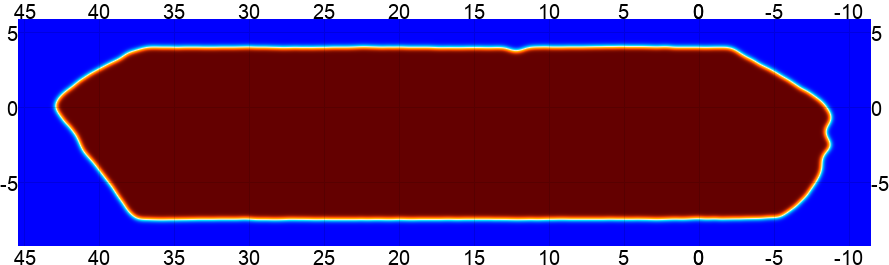

In [3]:
data_root = '/tigress/zequnl/cmb/data/steve_vs_amandadw/steve_sim0/'
apopath = f'{data_root}/mask_s14&15_deep56_apod.fits'
steve_apo = enmap.read_map(apopath)
box_shape, box_wcs = steve_apo.shape, steve_apo.wcs

eshow(steve_apo)

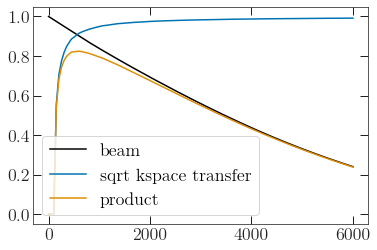

In [4]:
from soapack import interfaces

# read beam from soapack
mr3 = interfaces.ACTmr3()
beam = mr3.get_beam(ells=np.arange(6000), season="s15",patch="deep56",array="pa3_f090")
plt.plot(beam, '-', label='beam')

# read bins
binfile = f'{data_root}/BIN_ACTPOL_50_4_SC_low_ell_startAt2'
bins = nw.read_bins(binfile, is_Dell=True)

from scipy.interpolate import interp1d
tt_transfer = np.genfromtxt(f'{data_root}/tt_transf.txt')

# sanitize beam input, no negatives...
tt_transfer[np.logical_not(tt_transfer > 0.0)] = 1e-6
tt_transfer[np.isinf(tt_transfer)] = 1e-6

# linear interpolation of k-space transfer function
kspace_filter_effect_on_modes = interp1d(
    [0] + bins.get_effective_ells().tolist() + [10000], 
    np.sqrt([0] + ( (tt_transfer) ).tolist() + [1]), 
    kind='linear')

ell_beam = np.arange(len(beam))
plt.plot(ell_beam, kspace_filter_effect_on_modes(ell_beam), 
         '-',
         label=r'sqrt kspace transfer')

product_beam = beam * kspace_filter_effect_on_modes(ell_beam)
plt.plot(ell_beam, product_beam, '-', label='product')

plt.legend()
# plt.title('beam stuff')

In [5]:
def mapname(i):
    return (f"{data_root}/deep56_s15_pa3_f090_mr3f_" +
            f"20190502_191219_sim_w0_split{i}_0000_map.fits")

mask_file =  f"{data_root}/smask_s14&15_deep56_5.fits"
mask_pol_file =  f"{data_root}/smask_s14&15_deep56_8.fits"

# loop over splits and generate 
nsplits = 4
namap_list = [nw.namap_car(
    maps=enmap.read_map(f"{mapname(i)}"),
    masks=(enmap.read_map(mask_file), enmap.read_map(mask_pol_file)), 
    beams = product_beam,
    legacy_steve=True, kx=90, ky=50, sub_wcs=box_wcs, sub_shape=box_shape)
              for i in range(nsplits)]

Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: True
Applying legacy_steve correction.
Applying a k-space filter (kx=90, ky=50, apo=40), unpixwin: True
Computing spherical harmonics.

Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: True
Applying legacy_steve correction.
Applying a k-space filter (kx=90, ky=50, apo=40), unpixwin: True
Computing spherical harmonics.

Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: True
Applying legacy_steve correction.
Applying a k-space filter (kx=90, ky=50, apo=40), unpixwin: True
Computing spherical harmonics.

Assuming the same beams for both I and QU.
Creating a car namap. temperature: True, polarization: True
Applying legacy_steve correction.
Applying a k-space filter (kx=90, ky=50, apo=40), unpixwin: True
Computing spherical harmonics.



In [6]:
mc = nw.mode_coupling(namap_list[0], namap_list[1], bins, 
                      mcm_dir=f'{data_root}/mcm', 
                      overwrite=True
                     )

Computing new mode-coupling matrices.
Saving mode-coupling matrices to /tigress/zequnl/cmb/data/steve_vs_amandadw/steve_sim0//mcm


In [7]:
spec_dict = {}
TT_cross_spectra = []
TE_cross_spectra = []
EE_cross_spectra = []
# we reuse the mode coupling matrix `mc` from earlier
for i in range(len(namap_list)):
    for j in range(len(namap_list)):
        if i >= j:
            Cb = nw.compute_spectra(
                namap_list[i], namap_list[j], mc=mc)
            for clXY in Cb:
                spec_dict[f"{clXY},{i},{j}"] = Cb[clXY]
            if i > j:
                TT_cross_spectra += [Cb['TT']]
                TE_cross_spectra += [Cb['TE']]
                TE_cross_spectra += [Cb['ET']]
                EE_cross_spectra += [Cb['EE']]

mean_Cltt = np.sum(TT_cross_spectra, axis=0) / len(TT_cross_spectra)
se_Cltt = np.std(TT_cross_spectra, axis=0)/np.sqrt(len(TT_cross_spectra))

In [8]:
lb = mc.lb

In [9]:
# STEVE CHOI
lbin_sc, dltt_sc, dlte_sc, dlee_sc = np.loadtxt(
    f'{data_root}/d56_f090_sim0_spectra_from_steve.txt', unpack=True)
# AMANDA M
lbin_am, dltt_am, dlte_am, dlee_am = np.loadtxt(
    f'{data_root}/stevesim0_d56_f090.txt', unpack=True)
# THEORY
lbin_th,  TT_th, EE_th, BB_th,TE_th  = np.loadtxt(
    f'./lcdm.txt', unpack=True)

In [10]:
dbtt_th = mc.bins.bin_cell(
    (TT_th / (lbin_th * (lbin_th+1) / 2 / np.pi))
    [:mc.bins.lmax+1]
)

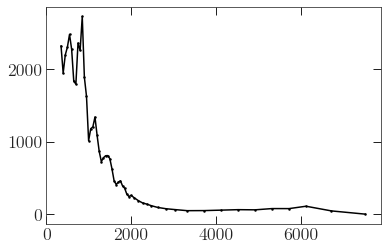

In [11]:
# plt.plot(lb, dbtt_th, '-')
plt.plot(lbin_sc, mean_Cltt[7:])
# plt.plot(lbin_am, transfer_TT)
# plt.plot(lbin_sc, dltt_sc / dltt_sc)
# plt.plot(lbin_sc, dltt_am[7:] / dltt_sc)
# plt.yscale('log')

# plt.ylim(-0.2, 2.2)

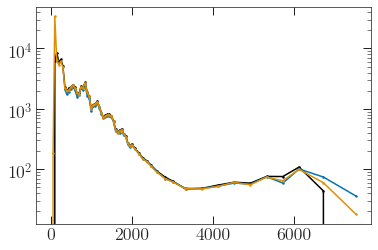

In [12]:
# plt.plot(lb, dbtt_th, '-')
plt.plot(lb, mean_Cltt)
# plt.plot(lbin_am, transfer_TT)
plt.plot(lbin_sc, dltt_sc)
plt.plot(lbin_am, dltt_am)
plt.yscale('log')
# plt.ylim(-0.2, 2.2)

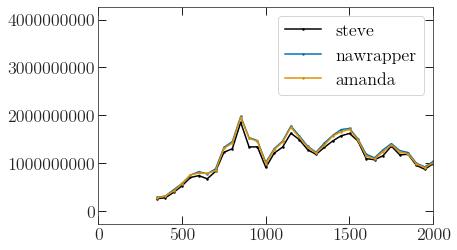

In [13]:
# plt.plot(lb, mean_Cltt)
plt.plot(lbin_sc, dltt_sc * lbin_sc**2, label='steve')
plt.plot(lbin_sc, mean_Cltt[7:] * lbin_sc**2 , label='nawrapper')
plt.plot(lbin_sc, dltt_am[7:] * lbin_sc**2, label='amanda')
# plt.axhline(0.0)
# plt.yscale('log')
# plt.ylim(-)
plt.xlim(0,2000)
# plt.ylim(2e5)
plt.legend()

In [16]:
np.savetxt('nawrapper_TT.txt', 
           np.array([lb, mean_Cltt]).T)

In [ ]:
! ls /tigress/zequnl/cmb/data/steve_vs_amandadw/steve_sim0/

In [ ]:
! cp /tigress/zequnl/cmb/data/steve_vs_amandadw/steve_sim0/test_steve_sim.py 